<img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> <div style="font-size: 25px">Data Science 2: Advanced Topics in Data Science</div>

## Lab 12b: cGAN with PyTorch and "GAN Hacks"
**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

# Introduction: Conditional GANs for Controlled Generation (CelebA)

In the previous notebook(s), we explored Unconditional GANs, specifically DCGAN, using Keras to generate Fashion-MNIST items. While successful in generating realistic items, the output was random – we couldn't tell the GAN *which* specific clothing item to create.

To achieve controllable generation, we need **Conditional GANs (cGANs)**. As discussed in the lecture, this involves providing conditioning information (like a class label) to both the Generator and the Discriminator.

**Challenges with Simple Conditioning:**

A naive approach might be to simply concatenate the label embedding with the input noise (for G) or the flattened features (for D). However, as experiments sometimes show (and perhaps you experienced if trying the initial PyTorch cGAN from earlier labs), this might not provide a strong enough signal. The Discriminator can often succeed by focusing only on image realism, effectively ignoring the label, which means the Generator doesn't learn to condition its output properly. The result? The generated images might look similar regardless of the input label.

**A More Robust Approach: Channel-wise Conditioning**

Inspired by cGAN architectures that have shown success (like the Keras reference we saw for Fashion-MNIST), we will implement a cGAN where the conditioning information is more deeply integrated:

1.  **Generator `G(z, y)`:** We will process the noise `z` and label `y` separately into initial spatial feature maps and then **concatenate them along the channel dimension** before the main upsampling convolutional layers.
2.  **Discriminator `D(x, y)`:** We will process the label `y` into a spatial map matching the input image `x` and **concatenate it as extra input channels** to the image *before* the first convolutional layer.

This forces both networks to process the image/noise features *in the context* of the label information right from the early layers.

**Goal & Framework:**

In this notebook, we will implement this channel-wise conditioned cGAN using **PyTorch** to generate CelebA face images conditioned on a specific attribute (e.g., 'Smiling'). We will highlight PyTorch-specific concepts compared to the Keras workflow students are more familiar with.

# 1. Setup and Configuration

We'll import necessary libraries and define key parameters for our dataset, models, and training process. Note the use of PyTorch libraries like `torch`, `torch.nn`, `torchvision`, and Hugging Face `datasets`.

In [1]:
# Imports and Basic Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils # For saving image grids
from torchmetrics.image.fid import FrechetInceptionDistance

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset # Using Hugging Face datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import os
import sys
import imageio # For GIF
import glob    # For finding files

# --- Configuration Settings ---

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    # Note the function name difference from the TF example
    print(f"CUDA device name: {torch.cuda.get_device_name(device)}")

# --- Data Parameters ---
IMG_SIZE = 64           # Target image size (CelebA images are larger originally)
BATCH_SIZE = 64
# Choose the attribute for conditioning from CelebA
# Common binary options: 'Smiling', 'Male', 'Young', 'Eyeglasses', 'Wearing_Hat', 'Heavy_Makeup'
ATTRIBUTE_NAME = 'Smiling'
INPUT_CHANNELS = 3      # CelebA are RGB images

# --- Model Hyperparameters ---
LATENT_DIM = 100        # Dimension of the input noise vector z
NUM_CLASSES = 2         # Binary attribute (e.g., Smiling=1, Not Smiling=0)
# Size of the learned label embedding. We will project this spatially later.
EMBEDDING_DIM = 50      # Can be tuned

# DCGAN Feature Map Sizes (common baseline)
NGF = 64 # Size of feature maps in generator
NDF = 64 # Size of feature maps in discriminator

# --- Training Strategy Flags ---
use_label_smoothing = True  
use_logits_loss = True     
use_spectral_norm = False  
use_feature_matching = True
use_instance_noise = True 

# --- Training Parameters ---
n_critic = 1              # Updates D once per G update (standard GAN/cGAN)
feature_matching_weight = 10.0 # Only relevant if use_feature_matching=True
initial_noise_std = 0.1     # Only relevant if use_instance_noise=True
noisy_epochs = 0.2          # Only relevant if use_instance_noise=True

# --- Optimization Parameters ---
learning_rate_g = 0.0002
learning_rate_d = 0.0002
beta1 = 0.5               # Adam optimizer beta1
beta2 = 0.999             # Adam optimizer beta2

# --- Loop Control & Saving ---
max_epochs = 200          # Adjust based on convergence and time
save_every = 5           # Save a generator checkpoint every N epochs
IMAGE_SAVE_DIR_CELEBA = './gan_generated_images_celeba_cgan' # Output directory
checkpoint_dir = Path(IMAGE_SAVE_DIR_CELEBA) / "checkpoints" # Subdirectory for model weights
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Will save images to: {IMAGE_SAVE_DIR_CELEBA}")
print(f"Will save checkpoints to: {checkpoint_dir}")


# --- Early Stopping Parameters ---
# Using FID requires torchmetrics - let's keep it simple for now or add later
early_stop_fid_delta = 0.0005
early_stop_patience = 15

# --- Label Definitions ---
real_label = 1.0 if not use_label_smoothing else 0.9
fake_label = 0.0

print("Configuration complete.")

Using device: cuda
CUDA device name: NVIDIA L4
Will save images to: ./gan_generated_images_celeba_cgan
Will save checkpoints to: gan_generated_images_celeba_cgan/checkpoints
Configuration complete.


# 2. Load and Prepare CelebA Dataset

We'll use the Hugging Face `datasets` library to load a version of the CelebA dataset that includes attributes. We need to:

1.  **Load:** Download/load the specified dataset split (e.g., `tpremoli/CelebA-attrs`). We can take a subset for faster experimentation if needed (e.g., `split='train[:50000]'`).
2.  **Create Wrapper:** Define a PyTorch `Dataset` class (`HuggingFaceCelebAWrapper`) to handle fetching items, applying transforms, and extracting the specific attribute label we chose (`ATTRIBUTE_NAME`). This involves mapping the attribute value (often -1/1 in CelebA) to 0/1.
3.  **Define Transforms:** Resize images to `IMG_SIZE`, center crop, convert to PyTorch tensors, and normalize pixel values to `[-1, 1]`.
4.  **Create DataLoader:** Use `torch.utils.data.DataLoader` to handle batching, shuffling, and parallel data loading. This is the PyTorch equivalent of `tf.data.Dataset.batch().shuffle()`.

--- Loading and Preparing CelebA Dataset ---
Attempting to load 'tpremoli/CelebA-attrs' split 'train'...


Generating train split:   0%|          | 0/162770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19867 [00:00<?, ? examples/s]

Successfully loaded dataset with 162770 samples.
Image transforms defined.
Wrapper configured for attribute 'Smiling'.
DataLoader created with batch size 64.

Checking sample batch...
  Image batch shape: torch.Size([64, 3, 64, 64])
  Label batch shape: torch.Size([64])
  Labels in batch: (tensor([0, 1]), tensor([33, 31]))


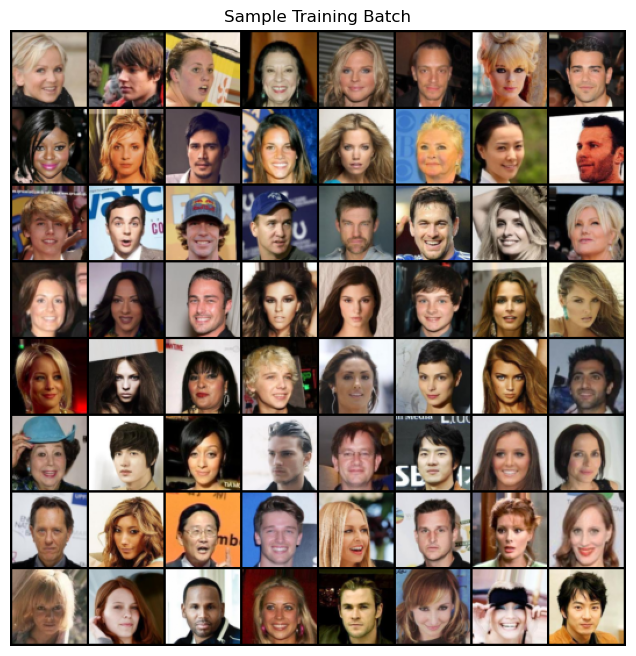

In [2]:
# Load and Prepare CelebA Dataset
print("--- Loading and Preparing CelebA Dataset ---")

# Hugging Face Cache Directory (Optional - set as needed)
cache_dir = "./hf_cache_celeba" # Example local cache
os.makedirs(cache_dir, exist_ok=True)

# --- Load Raw Dataset from Hugging Face ---
try:
    dataset_name_hf = "tpremoli/CelebA-attrs"
    # Load a subset for potentially faster iteration/debugging if needed
    # data_split = "train[:1000]" # Use subset
    data_split = "train" # Use the full training set
    print(f"Attempting to load '{dataset_name_hf}' split '{data_split}'...")
    raw_ds_hf = load_dataset(dataset_name_hf, split=data_split, cache_dir=cache_dir)
    print(f"Successfully loaded dataset with {len(raw_ds_hf)} samples.")
    # print("\nDataset features:")
    # print(raw_ds_hf.features) # Useful for confirming attribute names and types

except Exception as e:
    print(f"\nERROR: Failed to load dataset '{dataset_name_hf}'.")
    print(f"Error details: {e}")
    print("Please double-check the dataset identifier, split name, and internet connection.")
    # Exit or raise error if data loading is critical
    dataloader = None # Ensure dataloader isn't used if loading failed
    # sys.exit() # Uncomment to stop execution

# --- PyTorch Dataset Wrapper ---
# Handles fetching items, transforming, and extracting the target attribute
class HuggingFaceCelebAWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None, attribute_name='Smiling'):
        self.dataset = hf_dataset
        self.transform = transform
        self.attribute_name = attribute_name
        self.image_key = 'image' # Key for the PIL Image object in the dataset

        # Verify attribute exists
        if self.attribute_name not in self.dataset.features:
             available_attrs = [k for k in self.dataset.features.keys() if k not in ['image']]
             print(f"\nERROR: Attribute '{self.attribute_name}' not found!")
             print("Available attributes are:", available_attrs)
             raise ValueError(f"Invalid attribute name: {self.attribute_name}")
        print(f"Wrapper configured for attribute '{self.attribute_name}'.")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Get image and convert to RGB
        img = item[self.image_key].convert("RGB")
        # Apply transformations (Resize, Crop, ToTensor, Normalize)
        if self.transform:
            img = self.transform(img)

        # Get the attribute label (e.g., -1 or 1)
        label_val = item[self.attribute_name]
        # Map to 0 or 1 and ensure LongTensor type for nn.Embedding
        label = torch.tensor(int(max(0, label_val)), dtype=torch.long)

        return img, label

# --- Define Image Transformations ---
# Note: PyTorch transforms are slightly different from Keras layers
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),            # Resize smaller edge to IMG_SIZE
    transforms.CenterCrop(IMG_SIZE),        # Crop center to IMG_SIZE x IMG_SIZE
    transforms.ToTensor(),                  # Converts PIL Image (HWC, 0-255) to Tensor (CHW, 0.0-1.0)
    transforms.Normalize([0.5]*INPUT_CHANNELS, [0.5]*INPUT_CHANNELS) # Normalize [0,1] -> [-1,1]
])
print("Image transforms defined.")

# --- Create Dataset and DataLoader ---
if 'raw_ds_hf' in locals(): # Check if dataset loaded successfully
    try:
        celeba_dataset = HuggingFaceCelebAWrapper(raw_ds_hf, transform=transform, attribute_name=ATTRIBUTE_NAME)

        # DataLoader handles batching, shuffling, and parallel loading
        # num_workers > 0 speeds up loading but check compatibility/resource limits
        dataloader = DataLoader(
            celeba_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True, # Important to ensure consistent batch sizes for some operations
            num_workers=min(4, os.cpu_count()) # Use a few worker processes
        )
        print(f"DataLoader created with batch size {BATCH_SIZE}.")

        # --- Display Sample Batch ---
        try:
            print("\nChecking sample batch...")
            sample_batch = next(iter(dataloader))
            real_batch_imgs, real_batch_labels = sample_batch
            print(f"  Image batch shape: {real_batch_imgs.shape}") # Should be [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
            print(f"  Label batch shape: {real_batch_labels.shape}") # Should be [BATCH_SIZE]
            print(f"  Labels in batch: {real_batch_labels.unique(return_counts=True)}")
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Sample Training Batch")
            # Need to rearrange channels (CHW -> HWC) and de-normalize for display
            plt.imshow(np.transpose(vutils.make_grid(real_batch_imgs[:64], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()
        except Exception as e_batch:
             print(f"  Error checking batch: {e_batch}")

    except ValueError as e_wrap: # Catch attribute errors from wrapper
        print(f"\nERROR creating Dataset Wrapper: {e_wrap}")
        dataloader = None
    except Exception as e_load:
        print(f"\nERROR creating DataLoader: {e_load}")
        dataloader = None
else:
    print("Raw dataset not loaded, DataLoader not created.")

# 3. Define Conditional Generator Architecture

We adapt the DCGAN Generator architecture to accept both noise `z` and the label `y`. Following the reference cGAN strategy, we'll process noise and the embedded label into separate spatial feature maps and then concatenate them channel-wise before upsampling.

**PyTorch Implementation Details:**
*   Models are defined as classes inheriting from `torch.nn.Module`.
*   Layers are typically defined in the `__init__` method.
*   The computation flow is defined in the `forward` method.
*   We use `nn.Embedding` for labels, `nn.Linear` for projection, `view()` or `reshape()` (or `nn.Unflatten`) for reshaping tensors.
*   `nn.ConvTranspose2d` performs upsampling.
*   `nn.BatchNorm2d` and `nn.ReLU`/`nn.LeakyReLU` are used similarly to Keras.
*   `torch.cat([...], dim=1)` concatenates tensors along the channel dimension (dimension 1 in PyTorch's CHW format).

In [3]:
# Define Conditional Generator Architecture
import torch.nn as nn
import torch.nn.utils as nn_utils # For spectral norm later if needed

# --- Optional Spectral Norm Helper ---
# Although disabled for now, keep the helper for potential future use
# use_spectral_norm = False # Defined in config cell
def sn(module):
    """Applies spectral normalization if use_spectral_norm is True."""
    if use_spectral_norm:
        return nn_utils.spectral_norm(module)
    else:
        return module

class ConditionalConvGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, ngf=64, output_channels=3):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.ngf = ngf            # Base number of generator features
        self.output_channels = output_channels

        # --- Label Pathway ---
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        # Project embedding to match spatial size for concatenation (ngf channels, 4x4 size)
        self.label_proj = nn.Sequential(
            nn.Linear(embedding_dim, ngf * 4 * 4),
            # Reshape/Unflatten needed after linear
        )

        # --- Noise Pathway ---
        # Project noise to feature map size (ngf*7 channels, 4x4 size)
        # We'll combine noise (7 parts) and label (1 part) to get ngf*8 total channels
        self.noise_proj = nn.Sequential(
            nn.Linear(latent_dim, ngf * 7 * 4 * 4, bias=False),
            nn.BatchNorm1d(ngf * 7 * 4 * 4), # BN on the projected features
            nn.ReLU(True)
            # Reshape/Unflatten needed after linear
        )

        # --- Upsampling Body ---
        # Takes concatenated features (ngf*8 channels, 4x4 size)
        self.main = nn.Sequential(
            # Input state: (ngf*8) x 4 x 4
            # Note: bias=False because we use BatchNorm
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: ngf x 32 x 32

            nn.ConvTranspose2d(ngf, output_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh() # Output [-1, 1]
            # Final Output: output_channels x 64 x 64
        )

    def forward(self, z, labels):
        """
        z: Latent noise vector, shape (batch_size, latent_dim)
        labels: Conditional labels, shape (batch_size,) dtype=torch.long
        """
        batch_size = z.size(0)

        # --- Process Label ---
        c = self.label_embedding(labels)    # (B, embedding_dim)
        c = self.label_proj(c)              # (B, ngf * 4 * 4)
        # Reshape label features to (B, ngf, 4, 4)
        # Note: PyTorch uses Channels-Height-Width (CHW) format
        c_map = c.view(batch_size, self.ngf, 4, 4)

        # --- Process Noise ---
        n = self.noise_proj(z)              # (B, ngf * 7 * 4 * 4)
        # Reshape noise features to (B, ngf*7, 4, 4)
        n_map = n.view(batch_size, self.ngf * 7, 4, 4)

        # --- Concatenate along channel dimension (dim=1) ---
        # Result shape: (B, ngf*8, 4, 4)
        merged_input = torch.cat((n_map, c_map), dim=1)

        # --- Pass through upsampling layers ---
        output = self.main(merged_input)
        return output

# Instantiate the Generator
G = ConditionalConvGenerator(LATENT_DIM, NUM_CLASSES, EMBEDDING_DIM, ngf=NGF, output_channels=INPUT_CHANNELS).to(device)
print("--- Conditional Generator (Channel Concat) Summary ---")
# Basic parameter count (PyTorch doesn't have a built-in summary like Keras)
num_params_g = sum(p.numel() for p in G.parameters() if p.requires_grad)
print(f"Generator Parameters: {num_params_g:,}")
# print(G) # Uncomment to print layer structure

--- Conditional Generator (Channel Concat) Summary ---
Generator Parameters: 3,539,940


# 4. Define Conditional Discriminator Architecture

The Discriminator also needs to handle the conditional label input `y` alongside the image `x`. Following the channel-wise concatenation strategy:

**Architecture:**
1.  **Inputs:** Image `x` (`B, C, H, W`) and Label `y` (`B,`).
2.  **Label Pathway:** Embed the label `y` using `nn.Embedding`, project it using `nn.Linear` to have `H * W` features, and then `view`/`reshape` it into a spatial map `(B, 1, H, W)`.
3.  **Concatenation:** Concatenate the input image `x` and the reshaped label map `y_map` along the channel dimension (`dim=1`) to get `(B, C+1, H, W)`.
4.  **Main Body:** Pass this concatenated tensor through the standard DCGAN discriminator convolutional blocks (`Conv2d` with stride 2, `BatchNorm2d`, `LeakyReLU`). Note the *first* `nn.Conv2d` must have `in_channels = INPUT_CHANNELS + 1`.
5.  **Output:** Flatten the final feature map and pass it through a single `nn.Linear` layer to produce the output logit.

In [4]:
# Define Conditional Discriminator Architecture

class ConditionalConvDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, input_channels=3, input_size=64, ndf=64, use_logits=True):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.input_channels = input_channels
        self.input_size = input_size
        self.ndf = ndf
        # use_logits is implicitly True if we use BCEWithLogitsLoss and don't add sigmoid

        # --- Label Pathway ---
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        # Project embedding to H*W features, so it can be reshaped to a HxW map (1 channel)
        self.label_proj = nn.Sequential(
            nn.Linear(embedding_dim, input_size * input_size * 1),
            # Reshape happens in forward
        )

        # --- Main Convolutional Body ---
        # Takes concatenated image + label map (channels = input_channels + 1)
        self.main = nn.Sequential(
            # Input: (input_channels + 1) x 64 x 64
            # Note: bias=False because we use BatchNorm
            sn(nn.Conv2d(input_channels + 1, ndf, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # State: ndf x 32 x 32

            sn(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 16 x 16

            sn(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 8 x 8

            sn(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4
        )

        # --- Final Output Layer ---
        # Takes flattened features and outputs a single logit
        # Input features = ndf*8 channels * 4 * 4 spatial size
        self.final_layer = nn.Sequential(
            nn.Flatten(), # Flatten the output of main conv body
            sn(nn.Linear(ndf * 8 * 4 * 4, 1)) # Output 1 logit
        )

    def forward(self, x, labels, return_features=False):
        """
        x: Input image, shape (B, C, H, W)
        labels: Conditional labels, shape (B,) dtype=torch.long
        """
        batch_size = x.size(0)

        # --- Process Label ---
        c = self.label_embedding(labels)        # (B, embedding_dim)
        c = self.label_proj(c)                  # (B, H*W)
        # Reshape label features to map (B, 1, H, W)
        c_map = c.view(batch_size, 1, self.input_size, self.input_size)

        # --- Concatenate image and label map along channel dimension ---
        # Result shape: (B, C+1, H, W)
        merged_input = torch.cat((x, c_map), dim=1)

        # --- Pass through main convolutional layers ---
        features = self.main(merged_input) # Shape (B, ndf*8, 4, 4)

        # --- Get final logit output ---
        output = self.final_layer(features) # Shape (B, 1)

        # Return intermediate features if requested (e.g., for Feature Matching loss)
        # Return features from *before* flattening
        return (output, features) if return_features else output

# Instantiate the Discriminator
D = ConditionalConvDiscriminator(
    NUM_CLASSES, EMBEDDING_DIM, input_channels=INPUT_CHANNELS, input_size=IMG_SIZE, ndf=NDF
).to(device)
print("--- Conditional Discriminator (Channel Concat) Summary ---")
num_params_d = sum(p.numel() for p in D.parameters() if p.requires_grad)
print(f"Discriminator Parameters: {num_params_d:,}")
# print(D) # Uncomment to print layer structure

--- Conditional Discriminator (Channel Concat) Summary ---
Discriminator Parameters: 2,975,589


# 5. Define Loss, Optimizers, and Helpers

*   **Loss:** We use `nn.BCEWithLogitsLoss`, the PyTorch equivalent for binary cross-entropy operating on raw logits. This is generally preferred for numerical stability over adding a Sigmoid layer + `nn.BCELoss`.
*   **Optimizers:** We use `torch.optim.Adam` with `beta1=0.5` as common practice for GANs. Separate optimizers are needed for G and D.
*   **Helper Functions:** We need functions for saving/loading model checkpoints, preparing images for FID calculation (converting range/dtype), and the visualization function (which we'll enhance to save images).

In [5]:
# Define Loss, Optimizers, and Helpers
print("--- Defining Loss, Optimizers, and Helpers ---")

# --- Loss Function ---
adversarial_loss = nn.BCEWithLogitsLoss()
print(f"Using Loss: BCEWithLogitsLoss")

# --- Optimizers ---
# Standard Adam optimizer setup for GANs
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate_g, betas=(beta1, beta2))
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate_d, betas=(beta1, beta2))
print("Adam optimizers created.")

# --- FID Metric ---
# Requires installing torchmetrics: pip install torchmetrics
fid = FrechetInceptionDistance(feature=2048).to(device) # 2048 is standard
print("FID metric initialized (using feature layer 2048).")

# --- Helper Functions ---

def prepare_for_fid(imgs):
    """
    Converts images from [-1, 1] float to [0, 255] uint8 as required
    by torchmetrics FrechetInceptionDistance.
    """
    if not isinstance(imgs, torch.Tensor):
       imgs = torch.tensor(imgs) # Ensure it's a tensor

    # Detach from computation graph and move to CPU for robust conversion
    imgs = imgs.detach().cpu()

    # Denormalize from [-1, 1] to [0, 255]
    imgs = (imgs + 1.0) * 127.5

    # Clamp to the valid range [0, 255] and convert to uint8 (byte)
    imgs = imgs.clamp(0, 255).to(torch.uint8)

    # Ensure CHW format (which is typical for PyTorch Conv layers)
    # The FID metric should handle internal resizing/formatting if needed.
    # Example check: if imgs.ndim == 4 and imgs.shape[3] == 3: imgs = imgs.permute(0, 3, 1, 2)

    # Return the uint8 tensor (usually kept on CPU, torchmetrics handles device transfer)
    return imgs

def save_checkpoint(generator, discriminator, g_optimizer, d_optimizer, epoch, path):
    """Saves model and optimizer states."""
    # Ensure path is a Path object or string
    if not isinstance(path, Path): path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True) # Create directory if needed

    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'g_optimizer_state_dict': g_optimizer.state_dict(),
        'd_optimizer_state_dict': d_optimizer.state_dict(),
    }, path)
    print(f"✅ Saved checkpoint to {path} for epoch {epoch}")

def load_checkpoint(generator, discriminator, g_optimizer, d_optimizer, path):
    """Loads model and optimizer states."""
    start_epoch = 1
    if not isinstance(path, Path): path = Path(path)
    if path.exists():
        checkpoint = torch.load(path, map_location=device) # Load to target device
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"📦 Loaded checkpoint from {path}. Resuming from epoch {start_epoch}")
    else:
        print(f"⚠️ Checkpoint not found at {path}. Starting from epoch 1.")
    return start_epoch

# --- Updated Visualization Function (with Saving) ---
def visualize_conditional_samples(generator, latent_dim, num_classes, device, save_dir, epoch, num_samples_per_class=8, title_prefix="Conditional Samples"):
    """Generates, saves, and displays conditional samples."""
    generator.eval() # Set generator to evaluation mode
    samples = []
    # Use consistent noise across classes for better comparison
    fixed_noise = torch.randn(num_samples_per_class, latent_dim, device=device)

    with torch.no_grad(): # Disable gradient calculations for inference
        for i in range(num_classes):
            labels = torch.full((num_samples_per_class,), i, dtype=torch.long, device=device)
            generated_imgs = generator(fixed_noise, labels)
            samples.append(generated_imgs)

    # Concatenate samples from all classes into one tensor
    all_samples = torch.cat(samples, dim=0)

    # Create the grid using torchvision.utils.make_grid
    # normalize=True scales images to [0, 1] range for display/saving
    grid = vutils.make_grid(all_samples, nrow=num_samples_per_class, padding=2, normalize=True)

    # --- Save the image grid ---
    save_path = Path(save_dir) / f"samples_epoch_{epoch:04d}.png"
    try:
        vutils.save_image(grid, save_path)
        print(f"Saved sample grid to {save_path}")
    except Exception as e:
        print(f"Error saving sample grid: {e}")


    # --- Display the image grid ---
    plt.figure(figsize=(max(num_samples_per_class, 8), max(num_classes * 1.2, 8))) # Adjust figure size
    # Need to convert CHW (PyTorch) to HWC (Matplotlib)
    plt.imshow(grid.cpu().permute(1, 2, 0))
    plt.title(f"{title_prefix} - Epoch {epoch}")
    plt.axis('off')
    plt.show()

    generator.train() # Set generator back to training mode

print("Helper functions defined.")

--- Defining Loss, Optimizers, and Helpers ---
Using Loss: BCEWithLogitsLoss
Adam optimizers created.
FID metric initialized (using feature layer 2048).
Helper functions defined.


# 6. Training Loop

Now we implement the main training loop. This follows the standard adversarial process outlined in the lecture and seen in the Keras examples, but adapted for PyTorch.

**PyTorch Training Loop Structure:**

1.  **Outer Loop:** Iterates through epochs.
2.  **Inner Loop:** Iterates through batches provided by the `DataLoader`.
3.  **Device Transfer:** Move data (`images`, `labels`) to the GPU/CPU (`.to(device)`).
4.  **Discriminator Update (`n_critic` times):**
    *   Zero gradients (`D_optimizer.zero_grad()`): PyTorch gradients accumulate by default, so we must clear them before each backward pass.
    *   **Real Batch:** Pass real images and labels through D, calculate loss vs. `real_label` targets.
    *   **Fake Batch:** Generate fake images (`G(z, labels).detach()`). `.detach()` prevents gradients from flowing back into G during the D update. Pass fake images and labels through D, calculate loss vs. `fake_label` targets.
    *   **Combine Losses:** Sum real and fake losses.
    *   **Backpropagate:** Calculate gradients (`d_loss.backward()`).
    *   **Update Weights:** Apply gradients (`D_optimizer.step()`).
5.  **Generator Update (once per D cycle, or based on `n_critic`):**
    *   Zero gradients (`G_optimizer.zero_grad()`).
    *   **Generate Fakes:** Create fake images `G(z, random_labels)`. Using random labels can sometimes help G explore the conditional space better.
    *   **Classify Fakes:** Pass fake images and their intended labels through D.
    *   **Calculate Loss:** Compute loss vs. `real_label` targets (G wants D to think its fakes are real). Potentially add Feature Matching loss if enabled.
    *   **Backpropagate:** Calculate gradients (`g_loss.backward()`).
    *   **Update Weights:** Apply gradients (`G_optimizer.step()`).
6.  **Logging & Visualization:** Track losses, compute metrics (like FID), visualize generated samples, save checkpoints periodically.
7.  **No `model.fit()`:** Unlike Keras, PyTorch requires manually writing this training loop.

Starting training from scratch.

--- Starting Training ---
Epochs: 1 to 200 | Batch Size: 64 | Latent Dim: 100
Conditional Attribute: 'Smiling' | Num Classes: 2
Device: cuda
Settings: Label Smooth=True, Logits Loss=True, SN=False
Settings: Feature Match=True, Instance Noise=True


Epoch 0001/200:   0%|          | 0/2543 [00:00<?, ?it/s]

[0001/200] Avg D Loss: 0.8935 | Avg G Loss: 3.1395 | FID: 266.22122 | Noise Std: 0.1000
Saved sample grid to gan_generated_images_celeba_cgan/samples_epoch_0001.png


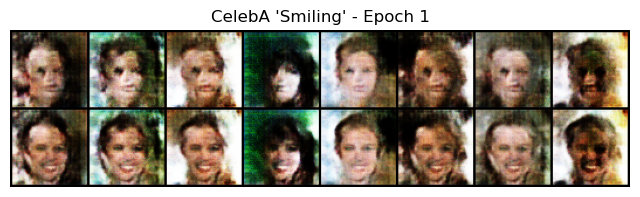

Epoch 0002/200:   0%|          | 0/2543 [00:00<?, ?it/s]

[0002/200] Avg D Loss: 0.7969 | Avg G Loss: 2.8474 | FID: 192.95485 | Noise Std: 0.0975
Saved sample grid to gan_generated_images_celeba_cgan/samples_epoch_0002.png


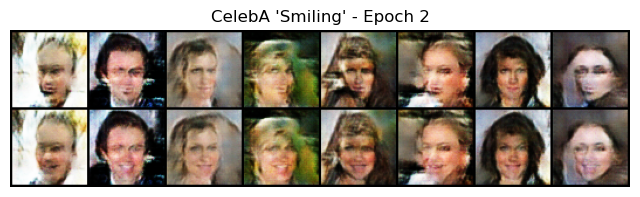

Epoch 0003/200:   0%|          | 0/2543 [00:00<?, ?it/s]

[0003/200] Avg D Loss: 0.8189 | Avg G Loss: 2.4283 | FID: 182.69749 | Noise Std: 0.0950
Saved sample grid to gan_generated_images_celeba_cgan/samples_epoch_0003.png


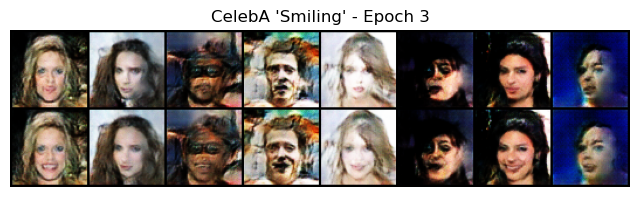

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14fdebc47880><function _MultiProcessingDataLoaderIter.__del__ at 0x14fdebc47880>

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14fdebc47880>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14fdebc47880>
Traceback (most recent call last):
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/

Epoch 0004/200:   0%|          | 0/2543 [00:00<?, ?it/s]

                self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()
self._shutdown_workers()
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():            if w.is_alive():
if w.is_alive():if w.is_alive():

 
                        ^^^^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/multiprocessing/process.py", 

[0004/200] Avg D Loss: 0.7900 | Avg G Loss: 2.4059 | FID: 165.85619 | Noise Std: 0.0925
Saved sample grid to gan_generated_images_celeba_cgan/samples_epoch_0004.png


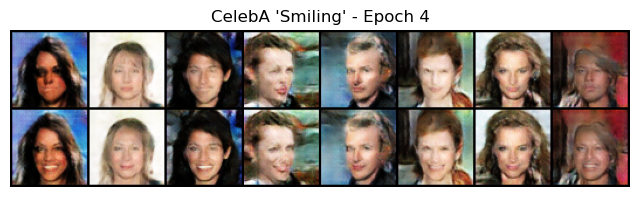

Epoch 0005/200:   0%|          | 0/2543 [00:00<?, ?it/s]

[0005/200] Avg D Loss: 0.7765 | Avg G Loss: 2.3923 | FID: 150.34923 | Noise Std: 0.0900
Saved sample grid to gan_generated_images_celeba_cgan/samples_epoch_0005.png


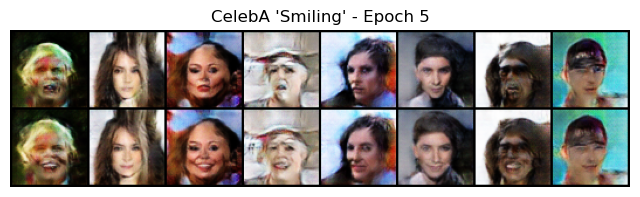

✅ Saved checkpoint to gan_generated_images_celeba_cgan/checkpoints/celeba_cgan_epoch_0005.pt for epoch 5
✅ FID improved to 150.34923


Epoch 0006/200:   0%|          | 0/2543 [00:00<?, ?it/s]

In [0]:
# Training Loop

# --- Check Prerequisites ---
if dataloader is None:
    print("ERROR: DataLoader is not defined. Please fix data loading cell.")
    # sys.exit() # Stop execution

latest_ckpt_path = None # Set to None to start fresh

if latest_ckpt_path and latest_ckpt_path.exists():
     start_epoch = load_checkpoint(G, D, G_optimizer, D_optimizer, latest_ckpt_path)
else:
     start_epoch = 1
     print("Starting training from scratch.")


# --- Training State ---
best_fid = float("inf") # Placeholder if not using FID
no_improve_epochs = 0
current_n_critic = n_critic # Use a modifiable variable

# Calculate actual number of epochs to apply noise
noisy_epoch_count = int(max_epochs * noisy_epochs)

print(f"\n--- Starting Training ---")
print(f"Epochs: {start_epoch} to {max_epochs} | Batch Size: {BATCH_SIZE} | Latent Dim: {LATENT_DIM}")
print(f"Conditional Attribute: '{ATTRIBUTE_NAME}' | Num Classes: {NUM_CLASSES}")
print(f"Device: {device}")
# Print relevant training flags
print(f"Settings: Label Smooth={use_label_smoothing}, Logits Loss={use_logits_loss}, SN={use_spectral_norm}")
print(f"Settings: Feature Match={use_feature_matching}, Instance Noise={use_instance_noise}")

# ============================
# ----- MAIN TRAIN LOOP -----
# ============================
for epoch in range(start_epoch, max_epochs + 1):
    G.train() # Set Generator to training mode
    D.train() # Set Discriminator to training mode
    g_losses_epoch, d_losses_epoch = [], [] # Track losses per epoch

    # --- Optional: Instance Noise Decay ---
    noise_std = 0.0
    if use_instance_noise and epoch <= noisy_epoch_count and noisy_epoch_count > 0:
        noise_std = initial_noise_std * max(0.0, 1.0 - (epoch - 1) / noisy_epoch_count)

    # Use tqdm for a progress bar over batches
    pbar = tqdm(dataloader, desc=f"Epoch {epoch:04d}/{max_epochs}", leave=True)

    for i, batch in enumerate(pbar):
        # --- Data Preparation ---
        real_imgs, real_labels = batch
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device).long() # Labels must be Long type for embedding
        current_batch_size = real_imgs.size(0) # Get actual batch size

        # Create targets on the correct device
        real_targets = torch.full((current_batch_size, 1), real_label, device=device, dtype=torch.float32)
        fake_targets = torch.full((current_batch_size, 1), fake_label, device=device, dtype=torch.float32)

        # --- Optional: Apply Instance Noise ---
        if use_instance_noise and noise_std > 0:
            real_imgs_noisy = real_imgs + noise_std * torch.randn_like(real_imgs)
            real_imgs_noisy = torch.clamp(real_imgs_noisy, -1.0, 1.0) # Clamp back to valid range
        else:
            real_imgs_noisy = real_imgs # Use original images if noise is off

        # =======================
        #   Train Discriminator
        # =======================
        # Train D more often than G if n_critic > 1
        for _ in range(current_n_critic):
            D_optimizer.zero_grad() # Clear previous gradients

            # --- Loss on Real Samples ---
            # Pass potentially noisy real images and their labels
            d_real_output = D(real_imgs_noisy, real_labels)
            d_loss_real = adversarial_loss(d_real_output, real_targets)

            # --- Loss on Fake Samples ---
            # Generate fake images - use torch.no_grad to avoid tracking G gradients here
            with torch.no_grad():
                z = torch.randn(current_batch_size, LATENT_DIM, device=device)
                # Condition on the same labels as the real batch
                fake_imgs = G(z, real_labels) # Output is already detached due to no_grad

            # Apply instance noise to fake images if enabled
            if use_instance_noise and noise_std > 0:
                fake_imgs_noisy = fake_imgs + noise_std * torch.randn_like(fake_imgs)
                fake_imgs_noisy = torch.clamp(fake_imgs_noisy, -1.0, 1.0)
            else:
                fake_imgs_noisy = fake_imgs

            # Pass fake images and their labels through D
            d_fake_output = D(fake_imgs_noisy, real_labels)
            d_loss_fake = adversarial_loss(d_fake_output, fake_targets)

            # --- Total Discriminator Loss & Update ---
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward() # Calculate gradients for D
            D_optimizer.step() # Update D weights

        # Record D loss from the last critic step for logging
        d_losses_epoch.append(d_loss.item())

        # ===================
        #   Train Generator
        # ===================
        # Typically train G once per batch (or every n_critic steps if > 1)
        G_optimizer.zero_grad() # Clear previous G gradients

        # --- Generate Fake Data for G Update ---
        z = torch.randn(current_batch_size, LATENT_DIM, device=device)
        # Use random labels for G update to encourage diverse conditional generation
        gen_labels = torch.randint(0, NUM_CLASSES, (current_batch_size,), device=device, dtype=torch.long)
        # Generate *clean* fake images (no noise added yet)
        gen_imgs = G(z, gen_labels)

        # Apply instance noise to generated images before feeding to D (if enabled)
        if use_instance_noise and noise_std > 0:
             gen_imgs_noisy = gen_imgs + noise_std * torch.randn_like(gen_imgs)
             gen_imgs_noisy = torch.clamp(gen_imgs_noisy, -1.0, 1.0)
        else:
             gen_imgs_noisy = gen_imgs

        # --- Calculate Generator Loss(es) ---
        fm_loss_val = 0.0 # For logging
        # Pass G's output (potentially noisy) through D with the intended labels
        if use_feature_matching:
             # Get D's prediction and intermediate features
             d_preds_fake, fake_features = D(gen_imgs_noisy, gen_labels, return_features=True)
             # Get features for real images (no gradients needed for D here)
             with torch.no_grad():
                 # Use original (clean) real images for stable FM target
                 _, real_features = D(real_imgs, real_labels, return_features=True)
             # Calculate Feature Matching loss (e.g., L1 distance between mean features)
             # Adjust mean dims based on feature map shape, e.g., mean over batch & spatial
             fm_loss = F.l1_loss(fake_features.mean(dim=[0, 2, 3]), real_features.mean(dim=[0, 2, 3]))
             fm_loss_val = fm_loss.item()
        else:
             # Only get D's prediction if not using FM
             d_preds_fake = D(gen_imgs_noisy, gen_labels)
             fm_loss = 0.0 # Ensure defined even if FM is off

        # Adversarial Loss: G wants D to classify these fakes as REAL
        g_adv_loss = adversarial_loss(d_preds_fake, real_targets) # Use real_targets (label 1 or 0.9)

        # --- Total Generator Loss & Update ---
        g_loss = g_adv_loss + feature_matching_weight * fm_loss if use_feature_matching else g_adv_loss
        g_loss.backward() # Calculate gradients for G
        G_optimizer.step() # Update G weights

        g_losses_epoch.append(g_loss.item())

        # --- Update Progress Bar ---
        pbar.set_postfix({
            "D Loss": f"{d_loss.item():.4f}", "G Loss": f"{g_loss.item():.4f}",
            "G Adv": f"{g_adv_loss.item():.4f}",
            "G FM": f"{fm_loss_val:.4f}" if use_feature_matching else "Off",
            "Noise": f"{noise_std:.3f}" if use_instance_noise else "Off",
            # "nC": current_n_critic
        })
        # --- End of Batch ---

    # =======================
    #   End of Epoch Actions
    # =======================
    pbar.close() # Close epoch progress bar

    # --- Calculate Average Losses ---
    avg_g_loss = np.mean(g_losses_epoch) if g_losses_epoch else 0
    avg_d_loss = np.mean(d_losses_epoch) if d_losses_epoch else 0

    # --- Calculate FID ---
    fid_score = float('inf') # Default if FID is disabled or fails
    # --- Update FID Score ---
    if fid is not None:
         # Prepare images OUTSIDE the main device context if prepare_for_fid moves to CPU
         # Explicitly move prepared tensors to fid.device
         fid_prep_real_imgs = prepare_for_fid(real_imgs).to(fid.device) # uint8, likely on CPU
         fid_prep_gen_imgs = prepare_for_fid(gen_imgs).to(fid.device)   # uint8, likely on CPU
    
         # Call fid.update
         with torch.no_grad():
            try:
                fid.update(fid_prep_real_imgs, real=True)
                fid.update(fid_prep_gen_imgs, real=False)
                fid_score = fid.compute().item()
            except Exception as e:
                print(f"Warning: Could not compute FID for epoch {epoch}: {e}")
            finally:
                fid.reset()
             # Note: Calculating FID every epoch can be very slow!

    # --- Logging ---
    log_message = f"[{epoch:04d}/{max_epochs}] Avg D Loss: {avg_d_loss:.4f} | Avg G Loss: {avg_g_loss:.4f}"
    log_message += f" | FID: {fid_score:.5f}"
    if use_instance_noise: log_message += f" | Noise Std: {noise_std:.4f}"
    print(log_message)

    # --- Visualize Conditional Samples & Save ---
    # Visualize more frequently early on, less frequently later
    vis_freq = 1 if epoch <= 10 else 5 if epoch <=50 else 10
    if epoch % vis_freq == 0 or epoch == 1 or epoch == max_epochs:
        try:
            visualize_conditional_samples(
                G, LATENT_DIM, NUM_CLASSES, device,
                save_dir=IMAGE_SAVE_DIR_CELEBA, # Pass save directory
                epoch=epoch,                    # Pass current epoch
                num_samples_per_class=8,
                title_prefix=f"CelebA '{ATTRIBUTE_NAME}'"
            )
        except NameError:
             print("Skipping visualization: `visualize_conditional_samples` function not defined.")
        except Exception as e:
             print(f"Error during visualization: {e}")


    # --- Save Checkpoint ---
    if epoch % save_every == 0 or epoch == max_epochs:
        try:
            ckpt_path = checkpoint_dir / f"celeba_cgan_epoch_{epoch:04d}.pt"
            save_checkpoint(G, D, G_optimizer, D_optimizer, epoch, ckpt_path)
        except NameError:
            print("Skipping checkpoint: `save_checkpoint` function not defined.")
        except Exception as e:
            print(f"Error during checkpoint saving: {e}")

    # --- Early Stopping with FID ---
        if fid_score < best_fid - early_stop_fid_delta:
            best_fid = fid_score
            no_improve_epochs = 0
            print(f"✅ FID improved to {best_fid:.5f}")
        else:
            no_improve_epochs += 1
            print(f"⚠️ No FID improvement for {no_improve_epochs} epoch(s). Best FID: {best_fid:.5f}")
    
        if no_improve_epochs >= early_stop_patience:
            print(f"⏹️ Early stopping triggered after {no_improve_epochs} epochs without FID improvement.")
            break

    # --- End of Training Loop ---

print("\n🏁 Training finished or stopped.")
print(f"Best FID achieved: {best_fid:.5f}")

# 7. Results and GIF Creation

After training, we can analyze the results:

*   **Loss Curves:** Plot the Generator and Discriminator losses. Look for signs of convergence, divergence, or oscillation.
*   **Generated Images:** Inspect the saved sample images from different epochs. Did the Generator learn to produce realistic faces? Crucially, does the 'Smiling' vs. 'Not Smiling' condition (or whichever attribute you chose) clearly manifest in the two rows of the generated grid?
*   **GIF:** Create an animated GIF from the saved epoch images to visualize the learning process over time.

In [0]:
# Results and GIF Creation

# --- Create Animated GIF ---
print(f"\n--- Creating CelebA cGAN Training Progress GIF ---")
GIF_FILENAME = f'celeba_{ATTRIBUTE_NAME}_cgan_training.gif'
GIF_PATH = Path(IMAGE_SAVE_DIR_CELEBA) / GIF_FILENAME
FRAME_DURATION = 0.2 # Seconds per frame (adjust speed)

# Find saved sample images, sorted by epoch number
filenames = sorted(list(Path(IMAGE_SAVE_DIR_CELEBA).glob('samples_epoch_*.png')))

if not filenames:
    print(f"Error: No sample images found in {IMAGE_SAVE_DIR_CELEBA}")
else:
    images = []
    image_skip = 1 # Use all frames
    print(f"Reading {len(filenames)} images (using every {image_skip} frame(s))...")
    for filename in tqdm(filenames[::image_skip]):
        try:
            images.append(imageio.imread(filename))
        except Exception as e:
            print(f"Warning: Could not read {filename}, skipping. Error: {e}")

    if images:
        print(f"Saving GIF ({len(images)} frames)...")
        try:
            imageio.mimsave(GIF_PATH, images, duration=FRAME_DURATION, loop=0)
            print(f"Successfully created GIF: {GIF_PATH}")
        except Exception as e:
            print(f"Error saving GIF: {e}")
    else:
        print("No valid images found to create GIF.")

    # Display GIF in notebook
    from IPython.display import Image as IPImage
    try:
        display(IPImage(filename=GIF_PATH))
    except NameError:
        print("Could not display GIF inline.")
    except FileNotFoundError:
         print("GIF file not found for display.")

# 8. Conclusion

In this notebook, we implemented a Conditional GAN using PyTorch, specifically designed to address potential conditioning failures by injecting the label information directly into the early stages of both the Generator and Discriminator via channel-wise concatenation. We trained it on the CelebA dataset to generate faces conditioned on the 'Smiling' attribute (or another chosen attribute).

By comparing the generated samples across different epochs (via the GIF) and examining the final outputs for clear conditional differences (e.g., smiling vs. non-smiling rows), we can assess the effectiveness of this cGAN architecture. This exercise highlights how architectural choices impact GAN training and demonstrates the transition from Keras concepts to a manual PyTorch training loop for generative models. Further improvements could involve incorporating techniques like Spectral Normalization, Feature Matching, or different loss functions if needed.